# Mô hình nhận diện tin tức giả

In [1]:
import os, csv, sys
import unicodedata as ud

from text_utils import remove_punc, token_sylabling, is_word


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

Update 1: pandas và sklearn có các phương thức hỗ trợ việc load dữ liệu, biểu diễn kết quả

In [2]:
import itertools
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

Một số thư viện hỗ trợ đánh giá mô hình và lưu trữ mô hình

In [3]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

GridSearchCV để kiếm thông số tốt nhất cho model, Pipeline để xây dựng mô hình chung

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.linear_model import SGDClassifier

Một số đường dẫn lưu và load file

In [6]:
models_path = './Models'

Vẽ Confusion Matrix theo dữ liệu

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## 1. Biểu diễn Bag-of-word

In [8]:
preproc_path = './PreprocessingData'

Chuẩn bị dữ liệu: Loại bỏ dấu câu, số, ngày tháng, url... -> Chuyển thành chữ viết thường

In [9]:
def data_preparing(text):
    text_list = text.lower().split()
    new_text = ''
    for word in text_list:
        if(is_word(word)):
            new_text = ' '.join([new_text, word])
    return new_text

### 1.1. Data 1:  file ```preproc_vn_news_226_tlfr.csv``` - text & label

In [10]:
data1_path = 'preproc_vn_news_226_tlfr.csv'

Load data từ file ```preproc_vn_news_226_tlfr.csv``` là các file đã được tiền xử lý, các record trong file đã được xáo trộn lên theo thứ tự ngẫu nhiên

In [11]:
news_data1 = []

data1_train_text = []
data1_train_label = []

data1_test_text = []
data1_test_label = []

In [12]:
with open(os.path.join(preproc_path, data1_path), 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    news_data1 = list(reader)

Tách dữ liệu thành 2 phần: ```Train``` - 181 record & ```Test``` - 45 record

In [13]:
train_size = 181

news_data1_train = news_data1[:train_size]
news_data1_test = news_data1[train_size:]

Chuẩn bị dữ liệu train

In [14]:
for train in news_data1_train:
    data1_train_text.append(data_preparing(train['text']))
    data1_train_label.append(train['label'])

Chuẩn bị dữ liệu test:
```data1_test_label```: chứa các label của dữ liệu test

In [15]:
for test in news_data1_test:
    data1_test_text.append(data_preparing(test['text']))
    data1_test_label.append(test['label'])

Biểu diễn Bag-of-Word cho dữ liệu ```train```

In [16]:
data1_tfidf_vectorizer = TfidfVectorizer()
X_data1_train_tfidf = data1_tfidf_vectorizer.fit_transform(data1_train_text)
print(X_data1_train_tfidf.shape)

(181, 7938)


### 1.2. Data 2:  file ```preproc_vn_news_223_tdlfr.csv``` - text & label

In [17]:
data2_path = 'preproc_vn_news_223_tdlfr.csv'

In [18]:
news_data2 = pd.read_csv(os.path.join(preproc_path, data2_path))

In [19]:
X_news_data2 = news_data2.drop('label', axis=1)
y_news_data2 = news_data2['label']

Thay đổi giá trị trong Dataframe của Pandas tham khảo tại:
1. [Set value for particular cell in pandas DataFrame with iloc](https://stackoverflow.com/questions/31569384/set-value-for-particular-cell-in-pandas-dataframe-with-iloc/31569794)
2. [Set value for particular cell in pandas DataFrame using index](https://stackoverflow.com/a/13842286/5144980)
3. [pandas.DataFrame.at - Pandas Doc](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.at.html?highlight=#pandas.DataFrame.at)
4. [pandas.DataFrame.iat](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iat.html?highlight=iat#pandas.DataFrame.iat)

In [20]:
for index in range(list(X_news_data2.shape)[0]):
    news = X_news_data2.iat[index, 0]
    X_news_data2.iat[index, 0] = data_preparing(news)

Chúng ta thêm 1 columns ```text_domain``` sẽ chứa nội dung của 2 cột: ```text``` và ```domain```, khi biểu diễn bag-of-word sẽ biểu diễn các vector cho trường ```domain```

In [21]:
X_news_data2['text_domain'] = X_news_data2['text'].map(str) + X_news_data2['domain']

Trộn dữ liệu và Split Train & Test bằng ```train_test_train```

In [22]:
X_news2_train, X_news2_test, y_news2_train, y_news2_test = train_test_split(X_news_data2, y_news_data2, test_size = 0.2)

#### Preprocessing Data2

Xử lý dữ liệu trên dataframe tham khảo tại:
1. [How to use sklearn fit_transform with pandas and return dataframe instead of numpy array?](https://stackoverflow.com/a/35724176/5144980)
2. [How to append TF-IDF vector into pandas dataframe ? - ResearchGate](https://www.researchgate.net/post/How_to_append_TF-IDF_vector_into_pandas_dataframe)
3. [Pandas to Sklearn](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62)
4. [Same TF-IDF Vectorizer for 2 data inputs](https://stackoverflow.com/questions/12850345/how-to-combine-two-data-frames-in-python-pandas)

Chọn 1 trong các hướng tiếp cận trên

__Vector hóa__: TFIDF vectorizer dữ liệu ```text``` của training data
1. ```data2_tfidf_vectorizer```: vectorize dữ liệu text lẫn domain
2. ```data2_domain_tfidf_vectorizer```: vectorize dữ liệu domain

In [23]:
data2_tfidf_vectorizer = TfidfVectorizer()
data2_domain_tfidf_vectorizer = TfidfVectorizer()

Dữ liệu train bao gồm ```text, domain```

In [24]:
X_data2_train_tfidf = data2_tfidf_vectorizer.fit_transform(X_news2_train['text_domain'])
print(X_data2_train_tfidf.shape)
# print(data2_tfidf_vectorizer.vocabulary_)

(178, 8164)


Dữ liệu train chỉ gồm ```domain```

In [25]:
X_data2_domain_train_tfidf = data2_domain_tfidf_vectorizer.fit_transform(X_news2_train['domain'])
print(X_data2_domain_train_tfidf.shape)

(178, 32)


## 2. Naive Bayes classification

### 2.1. Mô hình cho dữ liệu từ file ```preproc_vn_news_226_tlfr.csv``` - text & label

#### 2.1.1. Mô hình 1
Thực hiện tokenize bằng mô hình của nhóm -> Vectorize bằng TFIDF -> Thực hiện classify bằng Multinomial Naive Bayesian.

In [26]:
# MultiNB_clf_1 = MultinomialNB().fit(X_data1_train_tfidf, data1_train_label)
MultiNB_clf_1 = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('nbclf', MultinomialNB())
])
MultiNB_clf_1.fit(data1_train_text, data1_train_label)

Pipeline(memory=None,
     steps=[('tfidfvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tru...e,
        vocabulary=None)), ('nbclf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Ở đây biểu diễn test theo như mô hình TFIDFVectorize vừa tạo ở trên

In [27]:
X_test = data1_tfidf_vectorizer.transform(data1_test_text)

print('Chiều của dữ liệu Test: ',X_test.shape)

Chiều của dữ liệu Test:  (45, 7938)


In [28]:
data1_predict = MultiNB_clf_1.predict(data1_test_text)
data1_predict_log_proba = MultiNB_clf_1.predict_log_proba(data1_test_text)
data1_predict_proba = MultiNB_clf_1.predict_proba(data1_test_text)

Đánh giá Mô hình ```MultiNB_clf_1```:

1. __Accuracy__ của mô hình

In [29]:
np.mean(data1_test_label == data1_predict)

0.8888888888888888

2. __Confussion Matrix__

In [30]:
cnf_matrix = confusion_matrix(data1_test_label, data1_predict)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[25  1]
 [ 4 15]]


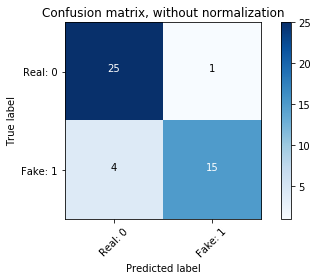

In [31]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [32]:
print(classification_report(data1_test_label, data1_predict, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.86      0.96      0.91        26
       Fake       0.94      0.79      0.86        19

avg / total       0.89      0.89      0.89        45



#### Lưu lại model1: ```MultiNB_clf_1```

In [33]:
model1_files = 'MultiNB_clf_1.sav'
joblib.dump(MultiNB_clf_1, os.path.join(models_path, model1_files))

['./Models/MultiNB_clf_1.sav']

#### 2.1.2 Tìm kiếm tham số tốt hơn cho mô hình 
Tham khảo thêm tại:
1. [Working with text data - SKLEARN](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
2. [SVM Parameter Tuning in Scikit Learn using GridSearchCV](https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0)

In [34]:
MultiNB_clf_2 = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('nbclf', MultinomialNB())
])

Các thông số kiểm chứng

In [35]:
parameters = {
    'tfidfvect__ngram_range': [(1, 1), (1, 2)],
    'tfidfvect__use_idf': (True, False),
    'nbclf__alpha': (1e-2, 1e-3),
}

In [36]:
gs_clf = GridSearchCV(MultiNB_clf_2, parameters, cv=5, iid=False, n_jobs=-1)

In [37]:
gs_clf = gs_clf.fit(data1_train_text, data1_train_label)

In [38]:
print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8945602745602745
nbclf__alpha: 0.01
tfidfvect__ngram_range: (1, 2)
tfidfvect__use_idf: True


#### 2.1.3. Xây dựng mô hình trên các tham số trên

In [39]:
MultiNB_text_clf = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range = (1, 2))),
    ('nbclf', MultinomialNB(alpha = 0.01))
])

In [40]:
MultiNB_text_clf.fit(data1_train_text, data1_train_label)

Pipeline(memory=None,
     steps=[('tfidfvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...,
        vocabulary=None)), ('nbclf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

##### Đánh giá mô hình

In [41]:
data1_predited_3 = MultiNB_text_clf.predict(data1_test_text)

1. __Accuracy__

In [42]:
np.mean(data1_predited_3 == data1_test_label)

0.9111111111111111

2. __Confussion Matrix__

In [43]:
cnf_matrix2 = confusion_matrix(y_pred=data1_predited_3, y_true=data1_test_label)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[23  3]
 [ 1 18]]


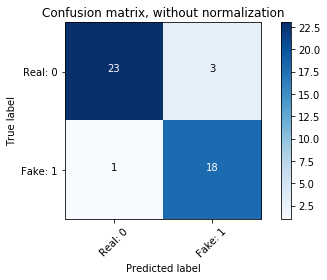

In [44]:
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [45]:
print(classification_report(y_true=data1_test_label, y_pred=data1_predited_3, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.96      0.88      0.92        26
       Fake       0.86      0.95      0.90        19

avg / total       0.92      0.91      0.91        45



#### Lưu lại model1: ```MultiNB_clf_1```

In [46]:
model1_files = 'MultiNB_clf_2.sav'
joblib.dump(MultiNB_text_clf, os.path.join(models_path, model1_files))

['./Models/MultiNB_clf_2.sav']

### 2.2. Mô hình cho dữ liệu từ file ```preproc_vn_news_223_tdlfr.csv``` - text, domain & label

#### 2.2.1. Mô hình & đánh giá
Nếu mô hình ở phần 1 dễ dàng đạt được do việc classify trên 1  tham số chính là text, ở đây chúng ta phải classify trên 2 feature: ```text``` và ```domain```

Tham khảo:
1. [How can I use sklearn.naive_bayes with (multiple) categorical features?](https://stackoverflow.com/a/38622421/5144980)

In [47]:
MultiNB_text_domain_clf_2 = MultinomialNB().fit(X_data2_train_tfidf, y_news2_train)

In [48]:
print(MultiNB_text_domain_clf_2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [49]:
MultiNB_domain_clf_2 = MultinomialNB().fit(X_data2_domain_train_tfidf, y_news2_train)

2 kết quả dự đoán trên 2 mô hình

In [50]:
X_data2_tokenizer = data2_tfidf_vectorizer.transform(X_news2_test['text_domain'])
y_predicted_text_domain = MultiNB_text_domain_clf_2.predict(X_data2_tokenizer)

In [51]:
X_data2_domain_tokenizer = data2_domain_tfidf_vectorizer.transform(X_news2_test['domain'])
y_predicted_domain = MultiNB_domain_clf_2.predict(X_data2_domain_tokenizer)

#### Đánh giá mô hình trên dataset Data2

1. __Accuracy__:

Mô hình ```Text & Domain```

In [52]:
np.mean(y_predicted_text_domain == y_news2_test)

0.8666666666666667

Mô hình ```Domain```: Overfit vì dữ liệu quá ít

In [53]:
np.mean(y_predicted_domain == y_news2_test)

0.9333333333333333

2. __Confusion Matrix__


Mô hình ```Text & Domain```

In [54]:
cnf_matrix_data2_dt = confusion_matrix(y_predicted_text_domain, y_news2_test)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[26  4]
 [ 2 13]]


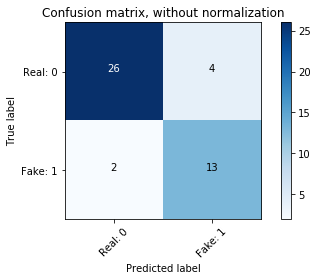

In [55]:
plt.figure()
plot_confusion_matrix(cnf_matrix_data2_dt, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [56]:
print(classification_report(y_predicted_text_domain, y_news2_test, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.93      0.87      0.90        30
       Fake       0.76      0.87      0.81        15

avg / total       0.87      0.87      0.87        45



#### Lưu lại model1: ```MultiNB_clf_textdomain_1```

In [57]:
model1_files = 'MultiNB_clf_textdomain_1.sav'
joblib.dump(MultiNB_text_domain_clf_2, os.path.join(models_path, model1_files))

['./Models/MultiNB_clf_textdomain_1.sav']

#### 2.2.2 Tìm kiếm tham số tốt hơn cho mô hình 
Tham khảo thêm tại:
1. [Working with text data - SKLEARN](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
2. [SVM Parameter Tuning in Scikit Learn using GridSearchCV](https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0)

In [58]:
MultiNB_domain_clf_2 = Pipeline([
    ('tfidfvect', TfidfVectorizer()),
    ('nbclf', MultinomialNB())
])

Các thông số kiểm chứng

In [59]:
parameters = {
    'tfidfvect__ngram_range': [(1, 1), (1, 2)],
    'tfidfvect__use_idf': (True, False),
    'nbclf__alpha': (1e-2, 1e-3),
}

In [60]:
gs_clf = GridSearchCV(MultiNB_domain_clf_2, parameters, cv=5, iid=False, n_jobs=-1)

In [61]:
gs_clf = gs_clf.fit(X_news2_train['text_domain'], y_news2_train)

In [62]:
print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.8985714285714286
nbclf__alpha: 0.01
tfidfvect__ngram_range: (1, 1)
tfidfvect__use_idf: False


#### 2.3. Xây dựng mô hình trên các tham số trên

In [63]:
MultiNB_text_domain_clf = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range = (1, 2))),
    ('nbclf', MultinomialNB(alpha = 0.001))
])

In [64]:
MultiNB_text_domain_clf.fit(X_news2_train['text_domain'], y_news2_train)

Pipeline(memory=None,
     steps=[('tfidfvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...
        vocabulary=None)), ('nbclf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

##### Đánh giá mô hình

In [65]:
y_predicted_text_domain3 = MultiNB_text_domain_clf.predict(X_news2_test['text_domain'])

1. __Accuracy__

In [66]:
np.mean(y_predicted_text_domain3 == y_news2_test)

0.8666666666666667

2. __Confussion Matrix__

In [67]:
cnf_matrix3 = confusion_matrix(y_pred=y_predicted_text_domain3, y_true=y_news2_test)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[24  4]
 [ 2 15]]


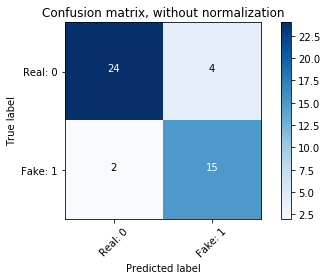

In [68]:
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [69]:
print(classification_report(y_true=y_news2_test, y_pred=y_predicted_text_domain3, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.92      0.86      0.89        28
       Fake       0.79      0.88      0.83        17

avg / total       0.87      0.87      0.87        45



#### Lưu lại model1: ```MultiNB_clf_textdomain_2```

In [70]:
model1_files = 'MultiNB_clf_textdomain_2.sav'
joblib.dump(MultiNB_text_domain_clf, os.path.join(models_path, model1_files))

['./Models/MultiNB_clf_textdomain_2.sav']

## 3. SVM classification

### 3.1. Mô hình cho dữ liệu từ file ```preproc_vn_news_226_tlfr.csv``` - text & label

#### Mô hình 1: 
Thực hiện tokenize bằng mô hình của nhóm -> Vectorize bằng TFIDF -> Thực hiện classify bằng SVM

In [71]:
svm1 = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
    ('svm', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None))
])

In [72]:
svm1.fit(data1_train_text, data1_train_label)

Pipeline(memory=None,
     steps=[('tfidfvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [73]:
svm_predict1 = svm1.predict(data1_test_text)

1. __Accuracy__

In [74]:
print(np.mean(svm_predict1 == data1_test_label))

0.8666666666666667


#### Lưu lại model1: ```SVM_clf_1```

In [75]:
model1_files = 'SVM_clf_1.sav'
joblib.dump(svm1, os.path.join(models_path, model1_files))

['./Models/SVM_clf_1.sav']

### 3.2. Mô hình cho dữ liệu từ file ```preproc_vn_news_223_tdlfr.csv``` - text, domain & label

In [76]:
svm2 = Pipeline([
    ('tfidfvect', TfidfVectorizer(ngram_range=(1, 2))),
    ('svm', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None))
])

In [77]:
svm2.fit(X_news2_train['text_domain'], y_news2_train)

Pipeline(memory=None,
     steps=[('tfidfvect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [78]:
svm_predict2 = svm2.predict(X_news2_test['text_domain'])

1. __Accuracy__

In [79]:
print(np.mean(svm_predict2 == y_news2_test))

0.9111111111111111


2. __Confussion Matrix__

In [80]:
cnf_matrix4 = confusion_matrix(y_pred=svm_predict2, y_true=y_news2_test)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[26  2]
 [ 2 15]]


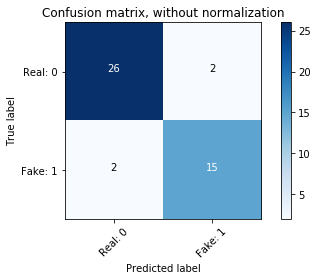

In [81]:
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes = ['Real: 0', 'Fake: 1'],
                      title='Confusion matrix, without normalization')

In [82]:
print(classification_report(y_true=y_news2_test, y_pred=svm_predict2, target_names=['Real', 'Fake']))

             precision    recall  f1-score   support

       Real       0.93      0.93      0.93        28
       Fake       0.88      0.88      0.88        17

avg / total       0.91      0.91      0.91        45



#### Lưu lại model1: ```SVM_clf_2```

In [83]:
model1_files = 'SVM_clf_2.sav'
joblib.dump(svm2, os.path.join(models_path, model1_files))

['./Models/SVM_clf_2.sav']